Just training of LSTM. Instead of taking into account moving average (possible by easy numpy calculation) taking into account all the points on time axis.

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
DAILY_STATS = './OpenData_Slovakia_Covid_DailyStats_Regions.csv'

df = pd.read_csv(DAILY_STATS, sep=';')

In [ ]:
df.head()


,Datum,Region,PCR_Pos,Ag_Neg,Ag_Pos,Total,Pocet.potvrdenych,Potvrdenych,newcases,date,positive
0,2022-06-26,Banskobystrický kraj,2,1,0,1,NaN,91529,2,2022-06-26,91529
1,2022-06-25,Banskobystrický kraj,15,0,0,0,NaN,91529,15,2022-06-25,91527
2,2022-06-24,Banskobystrický kraj,27,115,3,118,NaN,91529,30,2022-06-24,91512
3,2022-06-23,Banskobystrický kraj,24,591,7,598,NaN,91529,31,2022-06-23,91482
4,2022-06-22,Banskobystrický kraj,38,91,11,102,NaN,91529,49,2022-06-22,91451


In [ ]:
kosicky = df.loc[(df['Region']).isin(['Košický kraj'])]

In [ ]:
kosicky.head()

,Datum,Region,PCR_Pos,Ag_Neg,Ag_Pos,Total,Pocet.potvrdenych,Potvrdenych,newcases,date,positive
1666,2022-06-26,Košický kraj,8,27,9,36,NaN,110947,17,2022-06-26,110947
1667,2022-06-25,Košický kraj,35,45,14,59,NaN,110947,49,2022-06-25,110930
1668,2022-06-24,Košický kraj,52,154,29,183,NaN,110947,81,2022-06-24,110881
1669,2022-06-23,Košický kraj,36,362,20,382,NaN,110947,56,2022-06-23,110800
1670,2022-06-22,Košický kraj,33,205,21,226,NaN,110947,54,2022-06-22,110744


In [ ]:
new_cases_kosicky = df['newcases']

In [ ]:
new_cases_kosicky.describe()

count    6664.000000
mean      382.491146
std       610.596872
min         0.000000
25%         8.000000
50%        97.000000
75%       525.250000
max      4287.000000
Name: newcases, dtype: float64

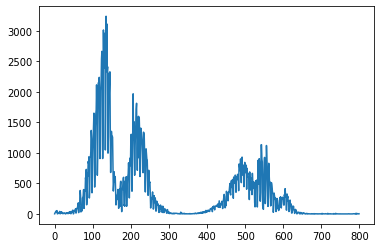

In [ ]:
plt.plot(new_cases_kosicky[:800])

In [ ]:
time_series = [x for x in range(0,6664)]


In [ ]:
scaler = MinMaxScaler(feature_range = (0 , 1))

In [ ]:
n_series = new_cases_kosicky.copy()

In [ ]:
n_series = np.expand_dims(n_series, axis=1)

In [ ]:
series_normalized = scaler.fit_transform(n_series)

In [ ]:
series_normalized

array([[0.00046653],
       [0.00349895],
       [0.0069979 ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [ ]:
# Hyperparameters

time = np.array(time_series)
series = np.array(new_cases_kosicky)
split_time = 5000
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000


In [ ]:
time_train = time[:split_time]
series_train = series[:split_time]

time_valid = time[split_time:]
series_valid = series[split_time:]

In [ ]:
len(series_train), len(series_valid), len(time_train), len(time_valid)


(5000, 1664, 5000, 1664)

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices(series_train)
train_set = train_set.window(window_size + 1, shift = 1, drop_remainder = True)
train_set = train_set.flat_map(lambda w: w.batch(window_size + 1))
train_set = train_set.shuffle(shuffle_buffer_size)
train_set = train_set.map(lambda w: (w[:-1], w[-1]))
train_set = train_set.batch(batch_size).prefetch(1)

In [ ]:
print(train_set)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [ ]:
model = tf.keras.models.Sequential ([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                               strides=1,
                               activation = 'relu',
                               padding= 'causal',
                               input_shape = [window_size,1]),
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(30, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(10)

])

# model = tf.keras.models.Sequential([ 
#       tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                     input_shape=[None]),
#       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
#       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
#       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
#       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#       tf.keras.layers.Dense(1),
#   ]) 

model.summary()
weights = model.get_weights()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 64, 64)            256       
                                                                 
 lstm_6 (LSTM)               (None, 64, 256)           328704    
                                                                 
 lstm_7 (LSTM)               (None, 64, 128)           197120    
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 30)                1950      
                                                                 
 dropout_5 (Dropout)         (None, 30)               

In [ ]:
print(weights)

In [ ]:
for lay in model.layers:
    print(lay.name)
    print(lay.get_weights)

In [ ]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = 'adam',
              metrics=['mae'])

In [ ]:
history = model.fit(train_set, epochs = 10)

Epoch 1/10
20/20 [==============================] - 79s 2s/step - loss: 387.3556 - mae: 387.8298
Epoch 2/10
20/20 [==============================] - 34s 2s/step - loss: 384.0978 - mae: 384.5732
Epoch 3/10
20/20 [==============================] - 36s 2s/step - loss: 379.6753 - mae: 380.1489
Epoch 4/10
20/20 [==============================] - 34s 2s/step - loss: 372.6299 - mae: 373.1057
Epoch 5/10
20/20 [==============================] - 34s 2s/step - loss: 362.8351 - mae: 363.3118
Epoch 6/10
20/20 [==============================] - 34s 2s/step - loss: 349.5996 - mae: 350.0761
Epoch 7/10
20/20 [==============================] - 34s 2s/step - loss: 332.9280 - mae: 333.4064
Epoch 8/10
20/20 [==============================] - 36s 2s/step - loss: 313.9753 - mae: 314.4554
Epoch 9/10
20/20 [==============================] - 34s 2s/step - loss: 293.2892 - mae: 293.7713
Epoch 10/10
20/20 [==============================] - 34s 2s/step - loss: 271.7075 - mae: 272.1906


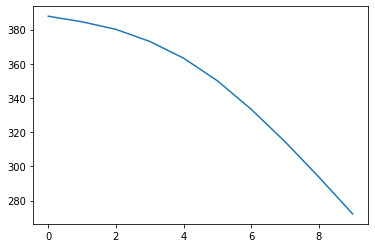

In [ ]:
plt.plot(history.history['mae'])

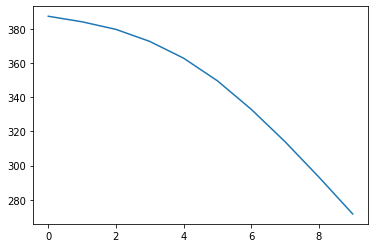

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
model.save('my_model.h5')

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, series, window_size).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[split_time - window_size:time_valid, -1]

rnn_forecast_2 = rnn_forecast[:+150]



# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(time_valid, series_valid)
plt.plot(rnn_forecast)


TypeError: ignored

In [ ]:
arnn_forecast

array([], dtype=float32)

In [ ]:
rnn_forecast_2 = rnn_forecast[:+1500]

In [ ]:
rnn_forecast_3 = rnn_forecast[0:split_time]

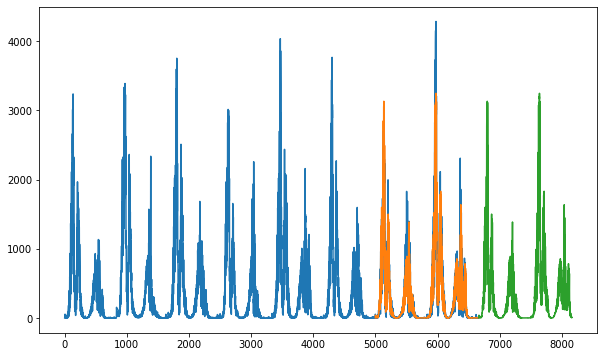

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.plot(time_valid, rnn_forecast_3)
plt.plot(range(6665, 6665+1500),rnn_forecast_2)

In [ ]:
rnn_forecast_2.shape

(150,)

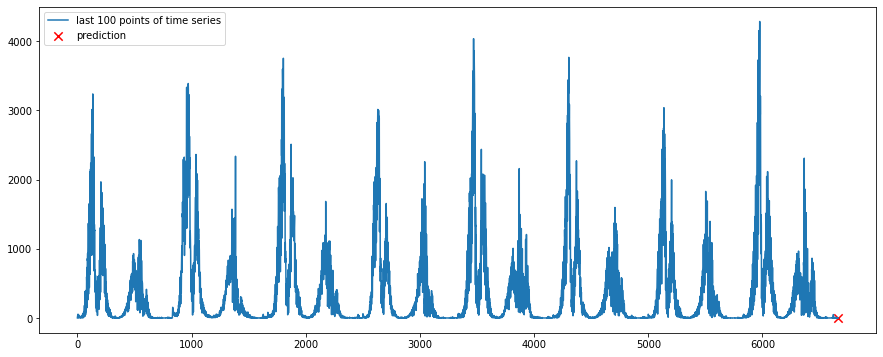

In [ ]:
new_forecast = []

new_forecast_series = series[-window_size:]

prediction = model.predict(new_forecast_series[np.newaxis])

plt.figure(figsize=(15, 6))
plt.plot(time[:], series[:], label="last 100 points of time series")
plt.scatter(max(time)+1, prediction, color="red", marker="x", s=70, label="prediction")
plt.legend()
plt.show()